## Multilayer Perceptron

One input layer, one hidden layer, one output layer. The units of the hidden layer are fully connected to the input layer and the output layer is fully connected to the input layer. If there is more than one hidden layer we call it a deep artificial neural network. 

Can include multiple units in the output layer for multicategory classification tasks

Activating a Neural Network Via Forward propagation

Multilayer Perceptron learning:
1. Forward propagate patterns of the training sdata through the network to generate an output
2. Based on output calculate error that we want to minimize using a cost function
3. Backpropagate the error find its derivative with respect to each wright in the network and update the model

Feedforward neural network- meaning that each leayer serves as an input to the next layer without loops. 

### Identifying hand written digits using MLP

In [1]:
import os
import struct
import numpy as np

def load_mnist(path,kind = 'train'):
    """Load MNIST data from `path`"""
    labels_path = os.path.join(path, '%s-labels-idx1-ubyte' % kind)
    images_path = os.path.join(path, '%s-images-idx3-ubyte' % kind)
    
    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II', lbpath.read(8))
        labels = np.fromfile(lbpath, dtype=np.uint8)
        
    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack(">IIII", imgpath.read(16))
        images = np.fromfile(imgpath, dtype=np.uint8).reshape(len(labels), 784)
    
    return images, labels

In [2]:
### read in images

magic,n = struct.unpack('>II', lbpath.read(8))
labels = np.fromfile(lbpath, dtype=np.int8)

NameError: name 'lbpath' is not defined

In [3]:
X_train, y_train = load_mnist('handwrittenImages', kind='train')
print ('Rows: %d, columns: %d' % (X_train.shape[0], X_train.shape[1]))

Rows: 60000, columns: 784


In [4]:
X_test, y_test = load_mnist('handwrittenImages', kind = 't10k')
print('Rows: %d, columns: %d' %(X_test.shape[0], X_test.shape[1]))

Rows: 10000, columns: 784


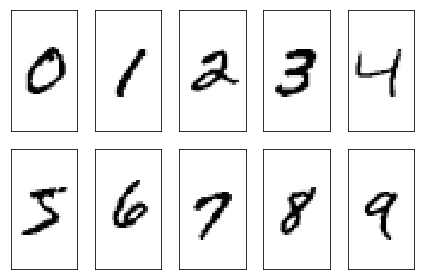

In [5]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows = 2, ncols = 5, sharex = True, sharey = True)
ax = ax.flatten() 
for i in range(10):
    img = X_train[y_train == i][0].reshape(28, 28)
    ax[i].imshow(img, cmap = 'Greys', interpolation = 'nearest')
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

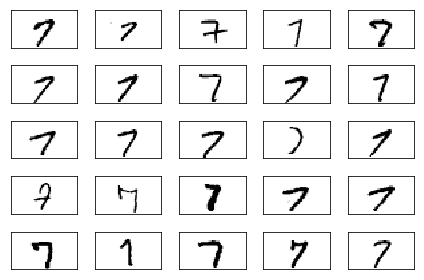

In [6]:
fig, ax = plt.subplots(nrows = 5, ncols = 5, sharex = True, sharey = True)
ax = ax.flatten()
for i in range(25):
    img = X_train[y_train == 7][i].reshape(28,28)
    ax[i].imshow(img, cmap="Greys", interpolation='nearest')
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

#### Implementing a Multilayer Perceptron

In [16]:
import numpy as np
from scipy.special import expit
import sys

class NeuralNetMLP(object):
    def __init__(self, n_output, n_features, n_hidden=30,
                 l1=0.0, l2=0.0, epochs=500, eta=0.001, 
                 alpha=0.0, decrease_const=0.0, shuffle=True, 
                 minibatches=1, random_state=None):
        np.random.seed(random_state)
        self.n_output = n_output
        self.n_features = n_features
        self.n_hidden = n_hidden
        self.w1, self.w2 = self._initialize_weights()
        self.l1 = l1
        self.l2 = l2
        self.epochs = epochs
        self.eta = eta
        self.alpha = alpha
        self.decrease_const = decrease_const
        self.shuffle = shuffle
        self.minibatches = minibatches

    def _encode_labels(self, y, k):
        onehot = np.zeros((k, y.shape[0]))
        for idx, val in enumerate(y):
            onehot[val, idx] = 1.0
        return onehot

    def _initialize_weights(self):
        w1 = np.random.uniform(-1.0, 1.0,       
                     size=self.n_hidden*(self.n_features + 1))
        w1 = w1.reshape(self.n_hidden, self.n_features + 1)
        w2 = np.random.uniform(-1.0, 1.0,
                     size=self.n_output*(self.n_hidden + 1))
        w2 = w2.reshape(self.n_output, self.n_hidden + 1)
        return w1, w2

    def _sigmoid(self, z):
        # expit is equivalent to 1.0/(1.0 + np.exp(-z))
        return expit(z)

    def _sigmoid_gradient(self, z):
        sg = self._sigmoid(z)
        return sg * (1 - sg)

    def _add_bias_unit(self, X, how='column'):
        if how == 'column':
            X_new = np.ones((X.shape[0], X.shape[1]+1))
            X_new[:, 1:] = X
        elif how == 'row':
            X_new = np.ones((X.shape[0]+1, X.shape[1]))
            X_new[1:, :] = X
        else:
            raise AttributeError('`how` must be `column` or `row`')
        return X_new

    def _feedforward(self, X, w1, w2):
        a1 = self._add_bias_unit(X, how='column')
        z2 = w1.dot(a1.T)
        a2 = self._sigmoid(z2)
        a2 = self._add_bias_unit(a2, how='row')
        z3 = w2.dot(a2)
        a3 = self._sigmoid(z3)
        return a1, z2, a2, z3, a3

    def _L2_reg(self, lambda_, w1, w2):
        return (lambda_/2.0) * (np.sum(w1[:, 1:] ** 2)\
                + np.sum(w2[:, 1:] ** 2))

    def _L1_reg(self, lambda_, w1, w2):
        return (lambda_/2.0) * (np.abs(w1[:, 1:]).sum()\
                + np.abs(w2[:, 1:]).sum())

    def _get_cost(self, y_enc, output, w1, w2):
        term1 = -y_enc * (np.log(output))
        term2 = (1 - y_enc) * np.log(1 - output)
        cost = np.sum(term1 - term2)
        L1_term = self._L1_reg(self.l1, w1, w2)
        L2_term = self._L2_reg(self.l2, w1, w2)
        cost = cost + L1_term + L2_term
        return cost

    def _get_gradient(self, a1, a2, a3, z2, y_enc, w1, w2):
        # backpropagation
        sigma3 = a3 - y_enc
        z2 = self._add_bias_unit(z2, how='row')
        sigma2 = w2.T.dot(sigma3) * self._sigmoid_gradient(z2)
        sigma2 = sigma2[1:, :]
        grad1 = sigma2.dot(a1)
        grad2 = sigma3.dot(a2.T)

        # regularize
        grad1[:, 1:] += (w1[:, 1:] * (self.l1 + self.l2))
        grad2[:, 1:] += (w2[:, 1:] * (self.l1 + self.l2))

        return grad1, grad2

    def predict(self, X):
        a1, z2, a2, z3, a3 = self._feedforward(X, self.w1, self.w2)
        y_pred = np.argmax(z3, axis=0)
        return y_pred

    def fit(self, X, y, print_progress=False):
        self.cost_ = []
        X_data, y_data = X.copy(), y.copy()
        y_enc = self._encode_labels(y, self.n_output)

        delta_w1_prev = np.zeros(self.w1.shape)
        delta_w2_prev = np.zeros(self.w2.shape)

        for i in range(self.epochs):

            # adaptive learning rate
            self.eta /= (1 + self.decrease_const*i)

            if print_progress:
                sys.stderr.write(
                        '\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                idx = np.random.permutation(y_data.shape[0])
                X_data, y_data = X_data[idx], y_data[idx]

            mini = np.array_split(range(
                         y_data.shape[0]), self.minibatches)
            for idx in mini:

                # feedforward
                a1, z2, a2, z3, a3 = self._feedforward(
                                     X[idx], self.w1, self.w2)
                cost = self._get_cost(y_enc=y_enc[:, idx],
                                      output=a3,
                                      w1=self.w1,
                                      w2=self.w2)
                self.cost_.append(cost)

                # compute gradient via backpropagation
                grad1, grad2 = self._get_gradient(a1=a1, a2=a2,
                                            a3=a3, z2=z2,
                                            y_enc=y_enc[:, idx],
                                            w1=self.w1,
                                            w2=self.w2)

                # update weights
                delta_w1, delta_w2 = self.eta * grad1,\
                                     self.eta * grad2
                self.w1 -= (delta_w1 + (self.alpha * delta_w1_prev))
                self.w2 -= (delta_w2 + (self.alpha * delta_w2_prev))
                delta_w1_prev, delta_w2_prev = delta_w1, delta_w2

        return self

In [17]:
>>> nn = NeuralNetMLP(n_output=10, 
...                   n_features=X_train.shape[1], 
...                   n_hidden=50, 
...                   l2=0.1, 
...                   l1=0.0, 
...                   epochs=1000, 
...                   eta=0.001,
...                   alpha=0.001,
...                   decrease_const=0.00001,
...                   shuffle=True,
...                   minibatches=50, 
...                   random_state=1)

l1: lambda parameter for L2 regularization to decrease the degree of overfitting

l2: lambda parameter for l1 regularization

epochs: number of passes over training set
eta: learning rate
alpha: momentum parameter for faster elarning (adds to previous gradient

decrease_const: decrease constant for adaptive learning rate n that decreases over time for better convergence

shuffle: shuffle training set prior to every epoch to prevent alogrithm from getting stuck in cycles

Minibatches: split data into k mini-batches in each epoch. Gradient is computed separately for each mini batch for faster learning. 

In [18]:
import datetime

print(datetime.datetime.now().time())

nn.fit(X_train, y_train, print_progress = True)

Epoch: 1/1000

12:56:42.019429


Epoch: 1000/1000

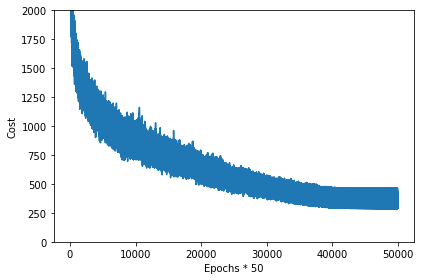

In [19]:
plt.plot(range(len(nn.cost_)), nn.cost_)
plt.ylim([0,2000])
plt.ylabel('Cost')
plt.xlabel('Epochs * 50')
plt.tight_layout()
plt.show()

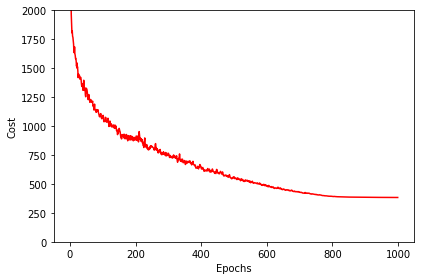

In [21]:
batches = np.array_split(range(len(nn.cost_)), 1000)
cost_ary = np.array(nn.cost_)
cost_avgs = [np.mean(cost_ary[i]) for i in batches]

plt.plot(range(len(cost_avgs)),
        cost_avgs, color='red')
plt.ylim([0,2000])
plt.ylabel('Cost')
plt.xlabel('Epochs')
plt.tight_layout()
plt.show()

In [53]:
# prediction accuracy

y_train_pred = np.array(nn.predict(X_train), dtype = 'uint8')
acc = float(np.sum(y_train == y_train_pred, axis = 0))
acc = acc/60000
print('Training accuracy: %.2f%%' % (acc *100))

Training accuracy: 97.50%


In [55]:
>>> y_test_pred = nn.predict(X_test)
>>> acc = float(np.sum(y_test == y_test_pred, axis=0)) / X_test.shape[0]
>>> print('Training accuracy: %.2f%%' % (acc * 100))

Training accuracy: 95.74%


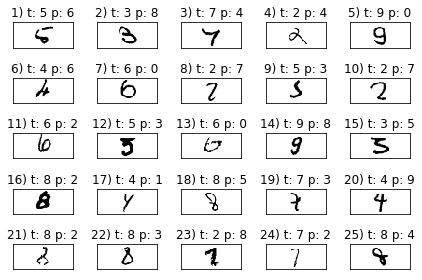

In [57]:
### Could tine the model better
    # hidden units, regularization, larning rate, values of the decrease constant
    # or adaptive learning. 
    
#Visualize the nunmbers the MLP struggles with
miscl_img = X_test[y_test != y_test_pred][:25]
correct_lab = y_test[y_test != y_test_pred][:25]
miscl_lab= y_test_pred[y_test != y_test_pred][:25]

fig, ax = plt.subplots(nrows=5, 
                       ncols=5, 
                       sharex=True, 
                       sharey=True,)
ax = ax.flatten()
for i in range(25):
    img = miscl_img[i].reshape(28, 28)
    ax[i].imshow(img, 
                 cmap='Greys', 
                 interpolation='nearest')
    ax[i].set_title('%d) t: %d p: %d' 
                    % (i+1, correct_lab[i], miscl_lab[i]))
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

In [36]:
y_train_pred

array([5, 0, 4, ..., 5, 6, 8])

In [38]:
np.array(y_train_pred, dtype= 'uint8')

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)